### Demonstration Goals
In this small project the purpose is to analyse some clustering models and evaluate them to find best model for selected dataset. I will not be foucusing more on Data Preparation and EDA part.

In [1]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, MeanShift
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import pairwise_distances
from sklearn import metrics

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter("ignore")

In [2]:
# Dataset: https://archive.ics.uci.edu/ml/datasets/Wholesale+customers
# Load data
wholesale_customers = pd.read_csv(r"D:\Datasets\Wholesale customers data.csv")
wholesale_customers.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [3]:
wholesale_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


In [4]:
wholesale_customers.describe()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,1.322727,2.543182,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,0.468052,0.774272,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,1.000000,1.000000,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,1.000000,2.000000,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,1.000000,3.000000,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,2.000000,3.000000,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,2.000000,3.000000,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


In [5]:
wholesale_customers.isnull().sum() # No null value

Channel             0
Region              0
Fresh               0
Milk                0
Grocery             0
Frozen              0
Detergents_Paper    0
Delicassen          0
dtype: int64

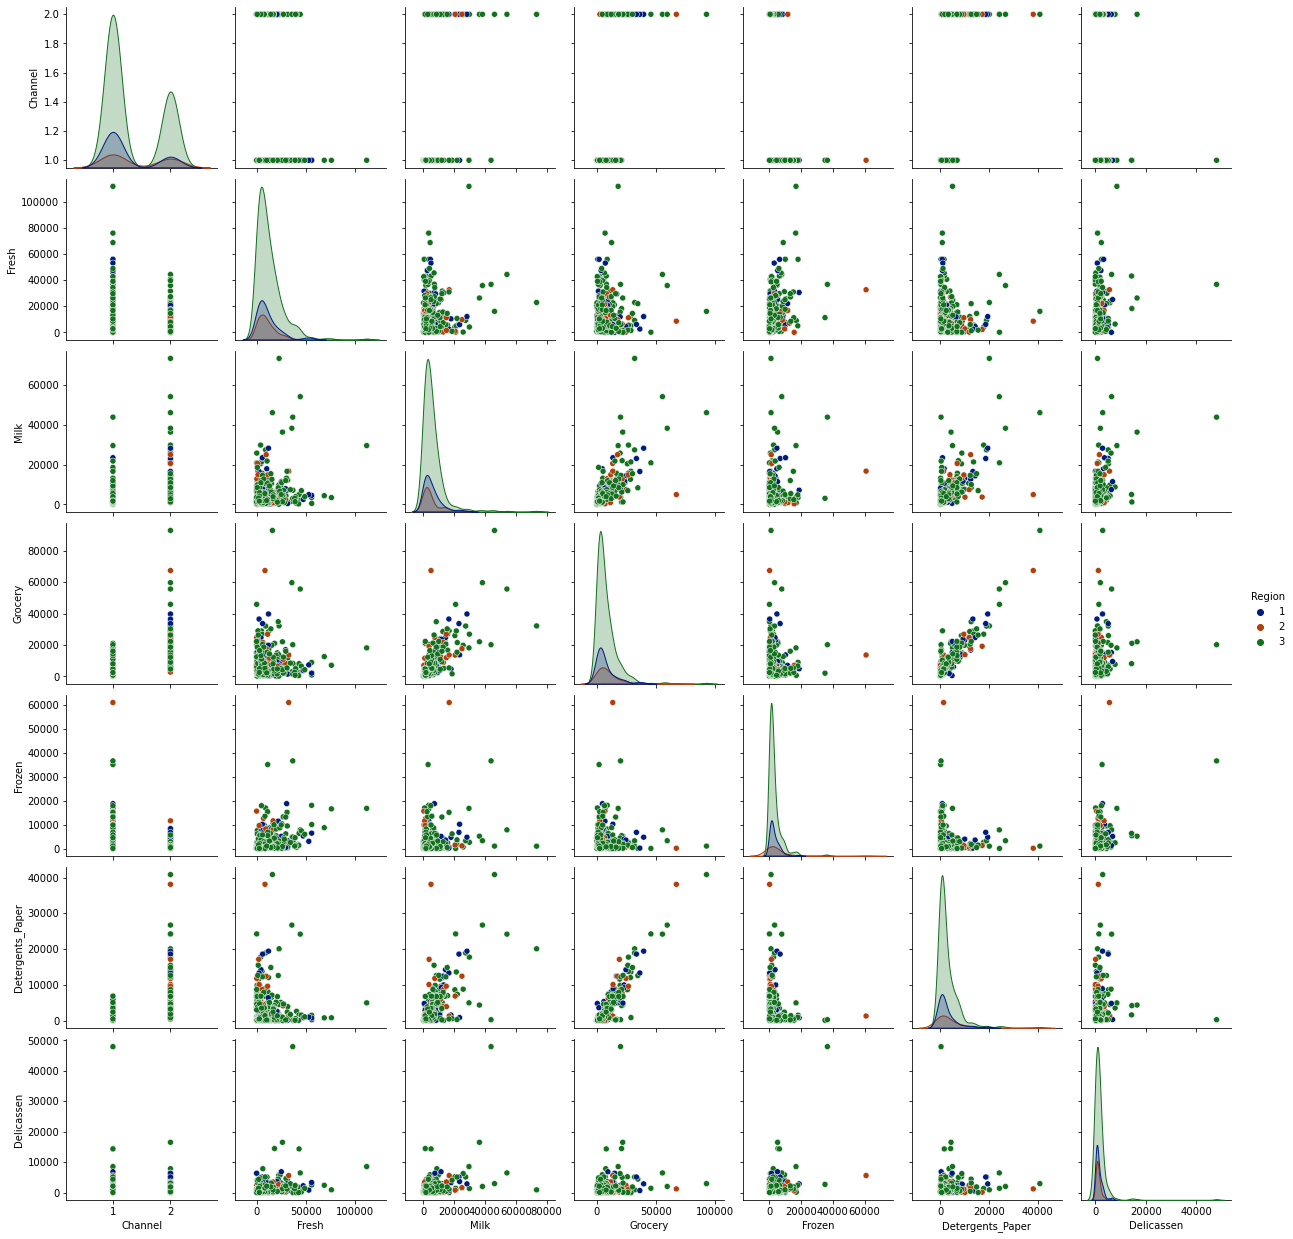

In [6]:
# Pairplot by hue = Region

sns.pairplot(wholesale_customers, hue='Region', palette='dark')

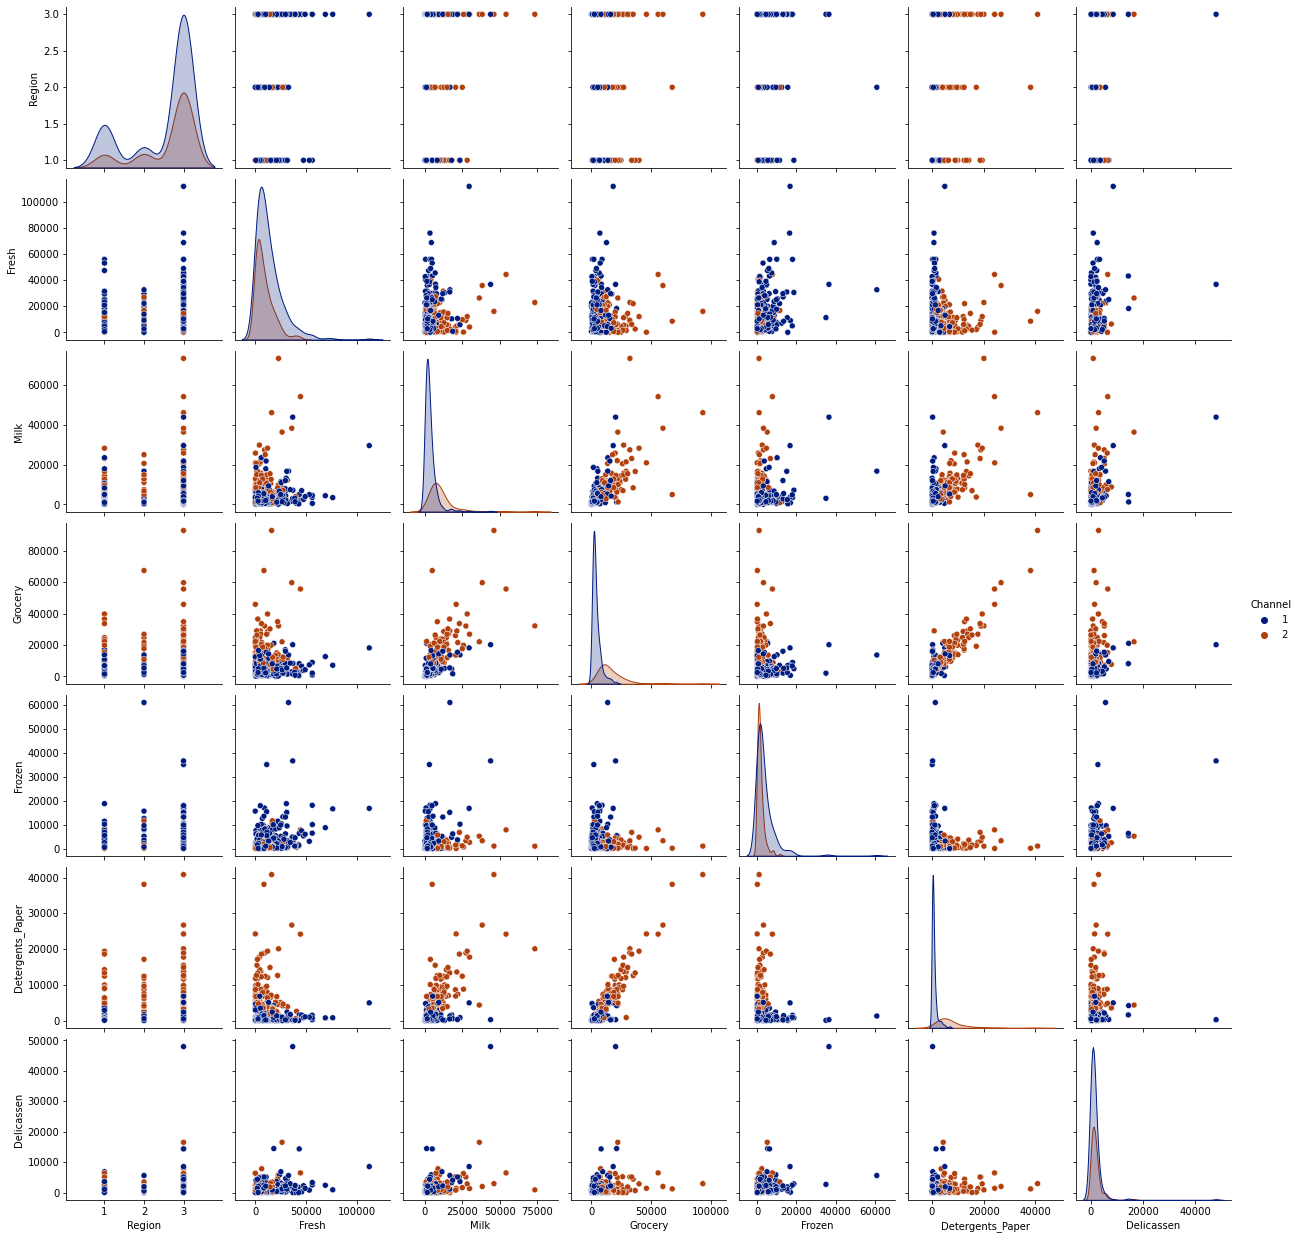

In [7]:
# Pairplot by hue = Channel

sns.pairplot(wholesale_customers, hue='Channel', palette='dark')

In [8]:
wholesale_customers.shape

(440, 8)

In [9]:
# Let us see data with respect to each region.
wholesale_customers['Region'].value_counts()

3    316
1     77
2     47
Name: Region, dtype: int64

<AxesSubplot:xlabel='Region', ylabel='count'>

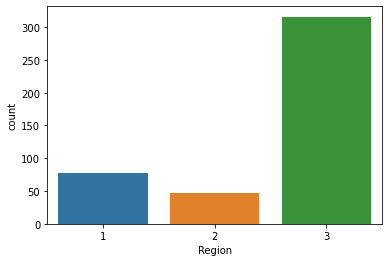

In [10]:
sns.countplot(data=wholesale_customers, x='Region')

In [11]:
# Basically there are 3 regions as follows:
# 1 Lisbon 77
# 2 Oporto 47
# 3 Other Region 316
# So 'Region' is actually one of the 2 target columns and we have to drop it while feeding data to clustering algorithm.

In [12]:
# Let us see data with respect to each Channel.
wholesale_customers['Channel'].value_counts()

1    298
2    142
Name: Channel, dtype: int64

<AxesSubplot:xlabel='Channel', ylabel='count'>

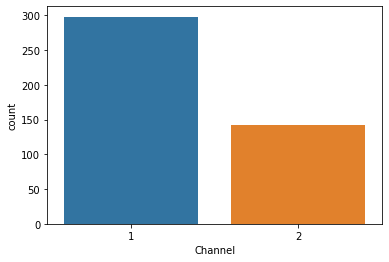

In [13]:
sns.countplot(data=wholesale_customers, x='Channel')

In [14]:
# There are 2 Channels as follows:
# 1 Horeca 298
# 2 Retail 142
# So 'Channel' is actually one of the 2 target columns and we have to drop it while feeding data to clustering algorithm.

In [15]:
# Let us scale data using MinMax scaling for computational efficiency.

trainingdata = wholesale_customers.copy().drop(['Region', 'Channel'], axis=1)
mms = MinMaxScaler()
trainingdata = mms.fit_transform(trainingdata)

### Selection of evaluation metric
We will be using silhouette score as evaluation metric for our clustering algorithms.

In [16]:
# Create a dictionary to save silhouette score for each algorithm.
silhouette_score_dict = {}

### KMeans Clustering

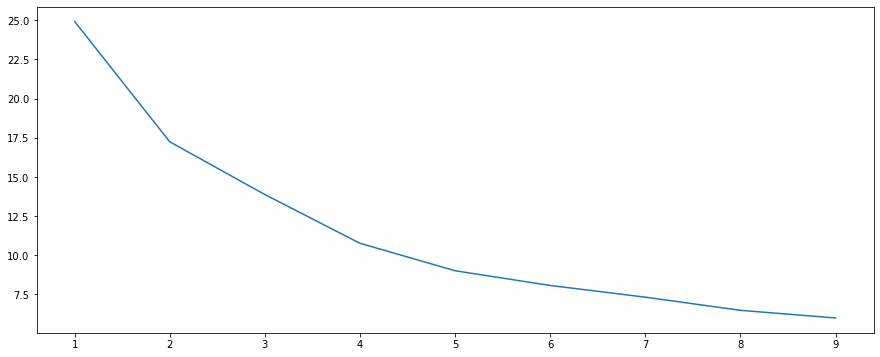

In [17]:
n = range(1, 10)
inertia = []
for num in n:
    km = KMeans(n_clusters = num, random_state=1)
    km = km.fit(trainingdata)
    inertia.append(km.inertia_)

plt.figure(figsize = (15,6))
plt.plot(n,inertia)

In [18]:
# We will select k = 2 as best k
km = KMeans(n_clusters = 2, random_state=1)
km = km.fit(trainingdata)
labels = km.labels_

In [19]:
kmeans_score = metrics.silhouette_score(trainingdata, labels, metric='euclidean')
kmeans_score

0.5766584987019181

In [20]:
silhouette_score_dict['KMeans Clustering'] = kmeans_score

### Agglomerative Clustering

In [21]:
# Create Agglomerative object and fit to data
agg = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
agg = agg.fit(trainingdata)
labels = agg.labels_

In [22]:
agg_score = metrics.silhouette_score(trainingdata, labels, metric='euclidean')
agg_score

0.34038518197273104

In [23]:
silhouette_score_dict['Agglomerative Clustering'] = agg_score

### DBSCAN Clustering

In [24]:
# Check how many clusters are created by varying parameters of DBSCAN.
i = range(1,5)
j = range(1,5)

for n in i:
    for m in j:
        dbscan = DBSCAN(eps = n, min_samples=m)
        dbscan = dbscan.fit(trainingdata)
        print(n, m, set(dbscan.labels_))

1 1 {0}
1 2 {0}
1 3 {0}
1 4 {0}
2 1 {0}
2 2 {0}
2 3 {0}
2 4 {0}
3 1 {0}
3 2 {0}
3 3 {0}
3 4 {0}
4 1 {0}
4 2 {0}
4 3 {0}
4 4 {0}


In [25]:
# Create DBSCAN object with default setting and fit data
dbscan = DBSCAN()
dbscan = dbscan.fit(trainingdata)
labels = dbscan.labels_

In [26]:
if set(labels) == {-1}:
    dbscan_score = 0
    print('Noisy sample is assigned label of -1.')
    print("DBSCAN is not working well for given data hence assigning Silhouette score = 0.")
elif len(set(labels)) == 1:
    dbscan_score = 0
    print('Only 1 cluster is created.')
    print("DBSCAN is not working well for given data hence assigning Silhouette score = 0.")
        
else:
    dbscan_score = metrics.silhouette_score(trainingdata, labels, metric='euclidean')

In [27]:
len(set(labels))

2

In [28]:
silhouette_score_dict['DBSCAN Clustering'] = dbscan_score

### Mean Shift Clustering

In [29]:
# Create Mean Shift object and fit to data
ms = MeanShift()
ms = ms.fit(trainingdata)
labels = ms.labels_

In [30]:
meanshift_score = metrics.silhouette_score(trainingdata, labels, metric='euclidean')
meanshift_score

0.4259392551496638

In [31]:
silhouette_score_dict['Mean Shift Clustering'] = meanshift_score

### Results

In [32]:
silhouette_score_dict

{'KMeans Clustering': 0.5766584987019181,
 'Agglomerative Clustering': 0.34038518197273104,
 'DBSCAN Clustering': 0.7832710580980035,
 'Mean Shift Clustering': 0.4259392551496638}

In [33]:
# Create dataframe of results
model = silhouette_score_dict.keys()
Silhouette_score = silhouette_score_dict.values()
comparison = pd.DataFrame(Silhouette_score, index=model, columns=['Silhouette_score'])
comparison

,Silhouette_score
KMeans Clustering,0.576658
Agglomerative Clustering,0.340385
DBSCAN Clustering,0.783271
Mean Shift Clustering,0.425939


In [34]:
# Get best score and best model
best_model = comparison[comparison['Silhouette_score']==comparison['Silhouette_score'].max()]['Silhouette_score'].index[0]
best_score = comparison[comparison['Silhouette_score']==comparison['Silhouette_score'].max()]['Silhouette_score'][0]

### Conclusion

In [35]:
print('The best score %0.4f is obtained by using {}.'.format(best_model) % (best_score))

The best score 0.7833 is obtained by using DBSCAN Clustering.


### Result Discussion
In this demonstration, we observed that DBSCAN clustering gave best result in clustering Wholsale Customers dataset. The Silhouette score for KMeans clustering somewhat good but very low for other algorithms. Scaling has improved performance of clustering algorithms.

### Further Steps
Here I used only 4 clustering algorithms in their simplest form. One can tune the hyperparametes to find best clustering model to apply. Other clustering algorithms can also be explored like Mini Batch KMeans clustering etc.
The models can also be evaluated using different evaluation methods to understand effect of different techniques on model performance. Different scaling methods can also be applied to see effect on performance